In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


# jet finding v5 ?

## thetalev

In [ ]:
ds = xr.Dataset()
ds["P"] = open_da("ERA5", "thetalev", "P", "6H", 1959, "JJA", -80, 20, 25, 75).load()
ds["u"] = open_da("ERA5", "thetalev", "u", "6H", 1959, "JJA", -80, 20, 25, 75).load()
ds["v"] = open_da("ERA5", "thetalev", "v", "6H", 1959, "JJA", -80, 20, 25, 75).load()
ds["s"] = open_da("ERA5", "thetalev", "s", "6H", 1959, "JJA", -80, 20, 25, 75).load()
ds["PV"] = open_da("ERA5", "thetalev", "PV", "6H", 1959, "JJA", -80, 20, 25, 75).load()

ds = compute_criterion(ds)

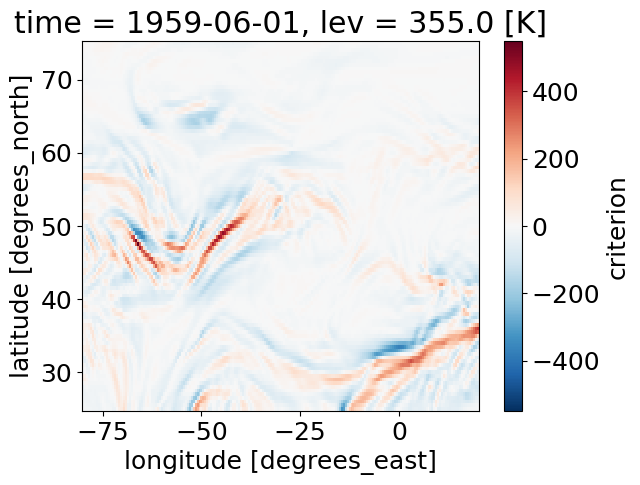

In [ ]:
(-ds["criterion"][0, 0]).plot()

In [ ]:
def mona_criterion(PV: xr.DataArray, cutoff: float = 0.4):
    criterion = smooth(PV, {"lon+lat": ("fft", 0.4)})
    criterion = np.log(criterion)
    criterion = criterion.differentiate("lon") ** 2 + criterion.differentiate("lat") ** 2
    return np.sqrt(criterion)

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


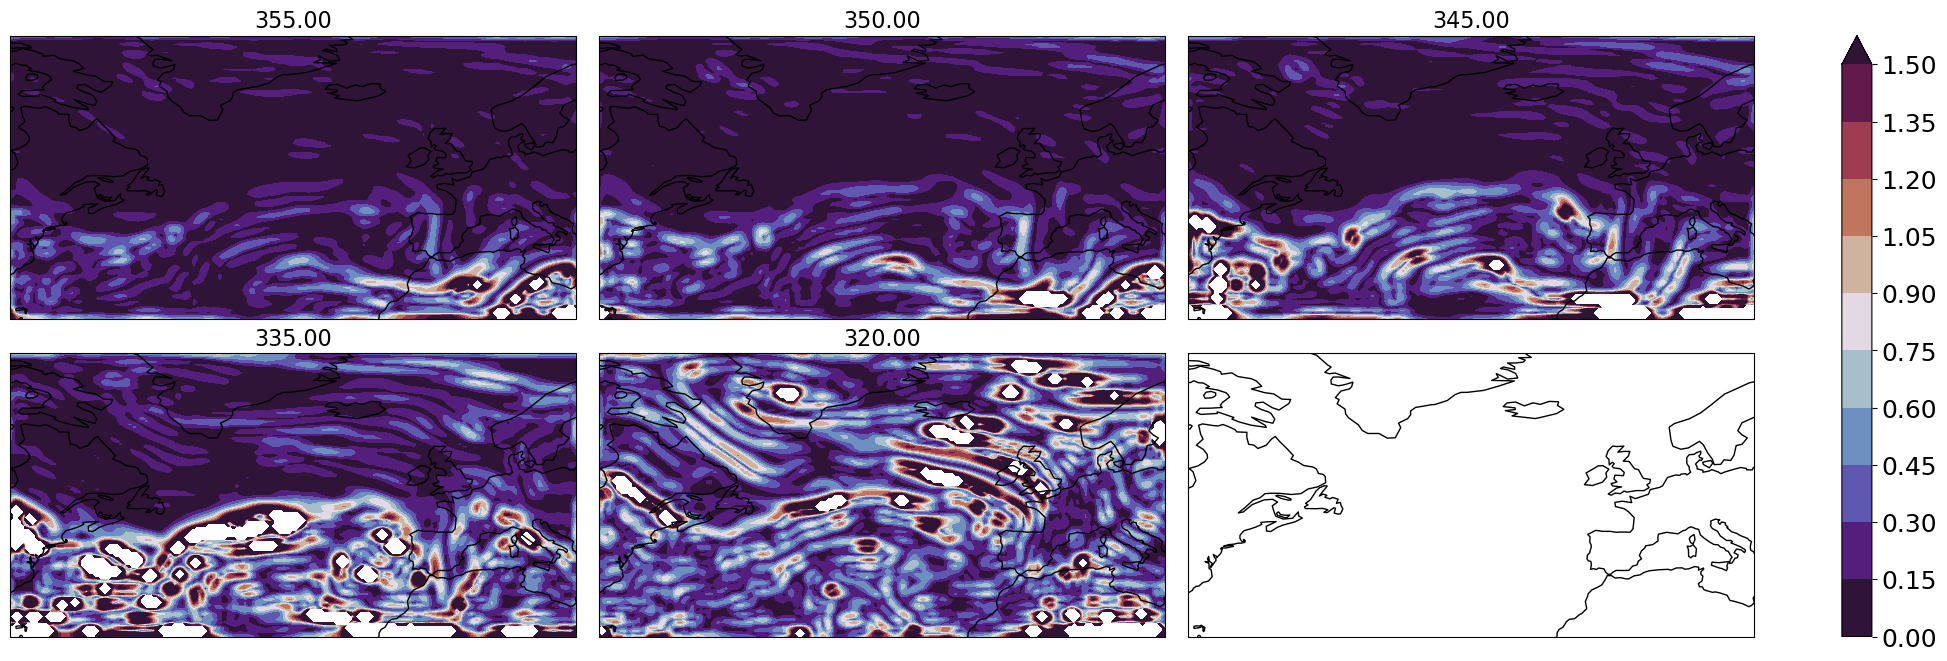

In [ ]:
clu = Clusterplot(2, 3, get_region(ds["P"]))
_ = clu.add_contourf([mona_criterion(ds["PV"][100, itheta], cutoff=0.8) for itheta in range(5)], nlevels=11, q=0.95, titles=ds.lev.values)

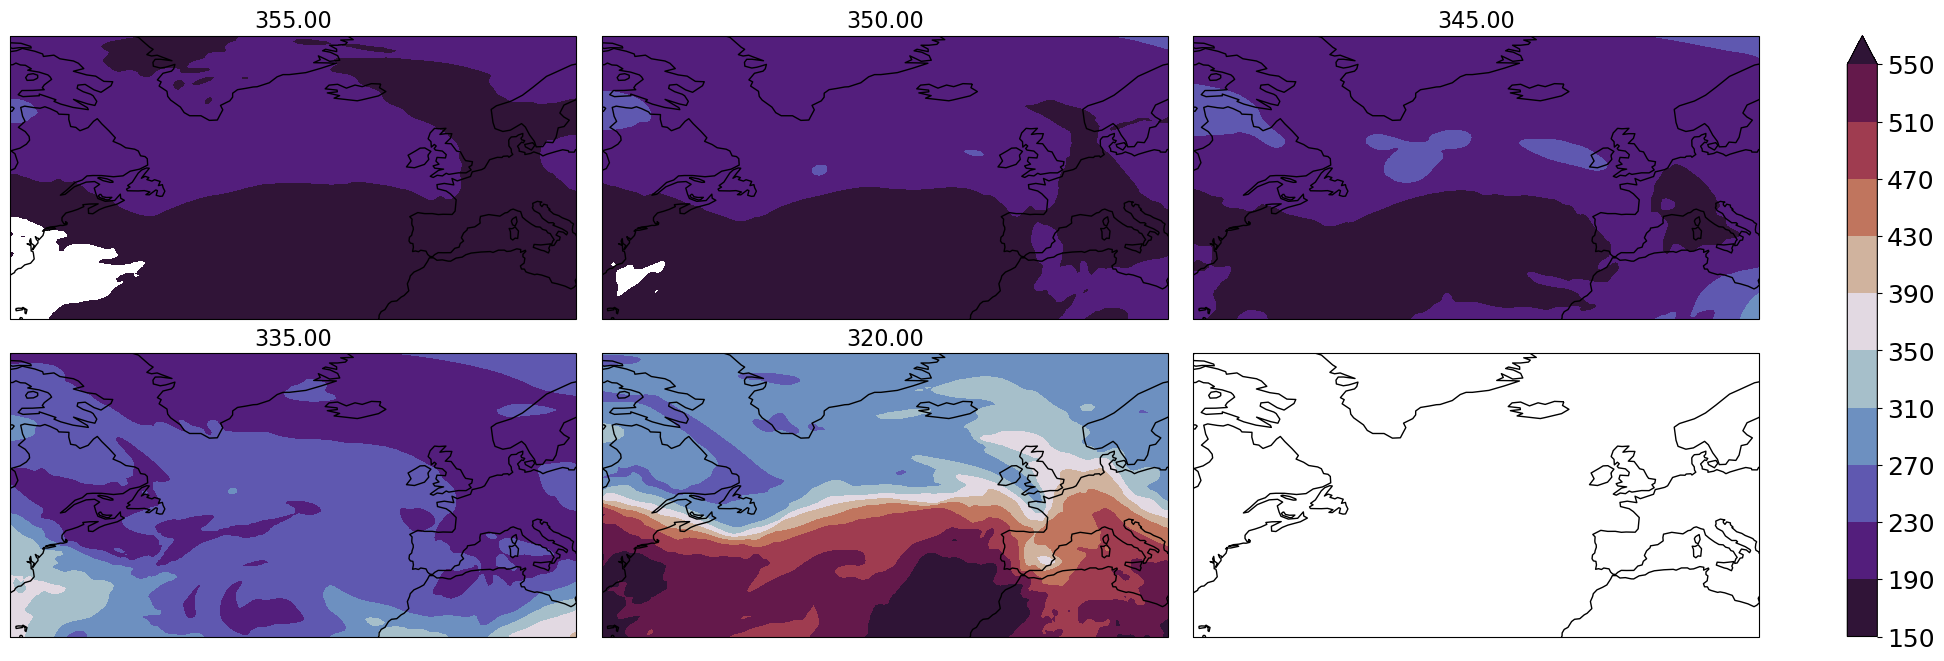

In [ ]:
clu = Clusterplot(2, 3, get_region(ds["P"]))
_ = clu.add_contourf([ds["P"][100, itheta] for itheta in range(5)], nlevels=11, q=0.95, titles=ds.lev.values)

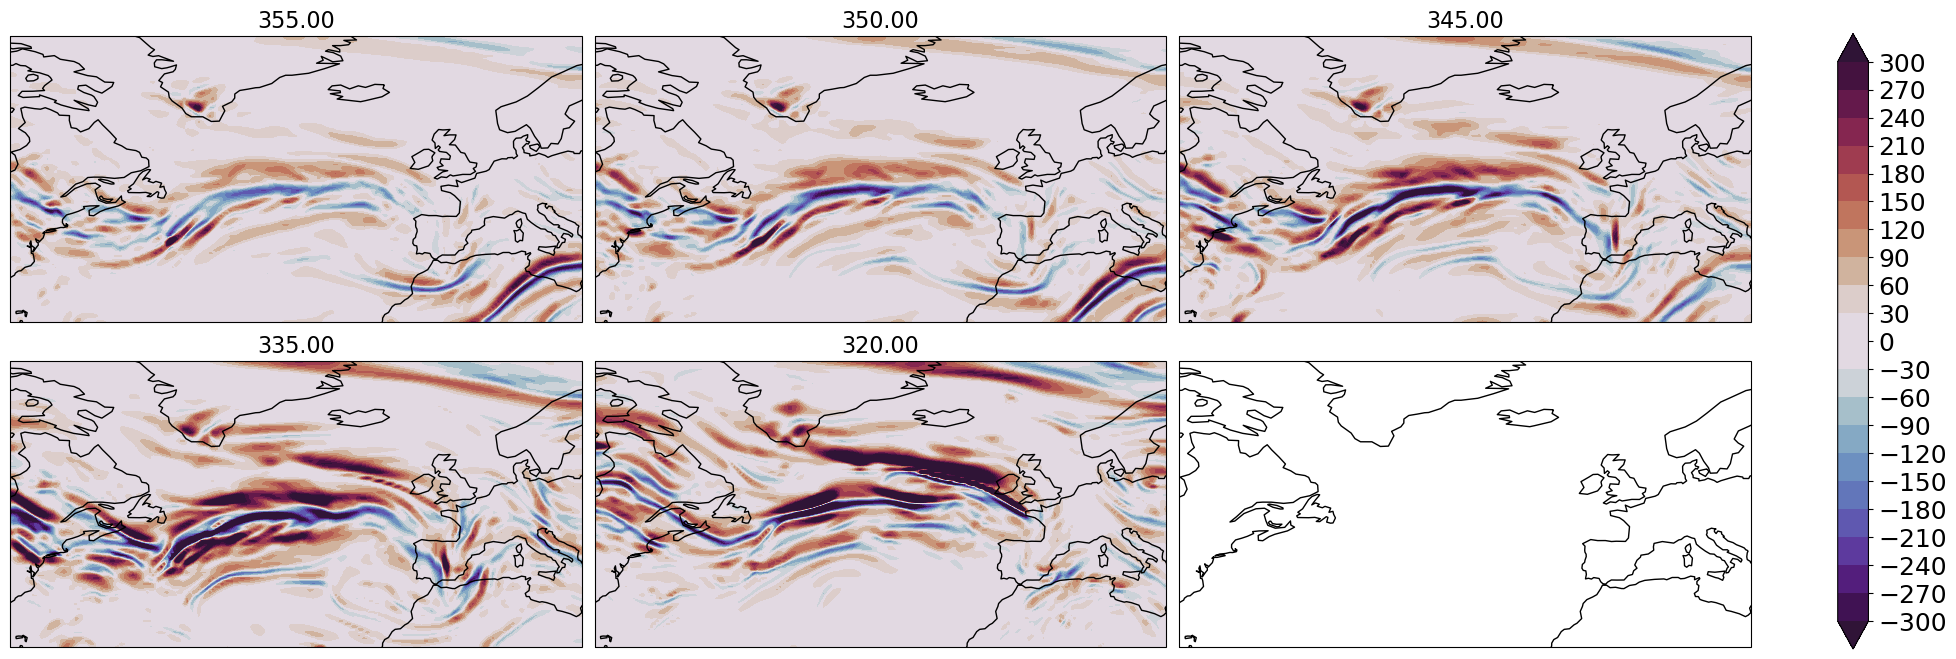

In [ ]:
clu = Clusterplot(2, 3, get_region(ds["P"]))
_ = clu.add_contourf([ds["criterion"][100, itheta] for itheta in range(5)], nlevels=11, q=0.99, titles=ds.lev.values)

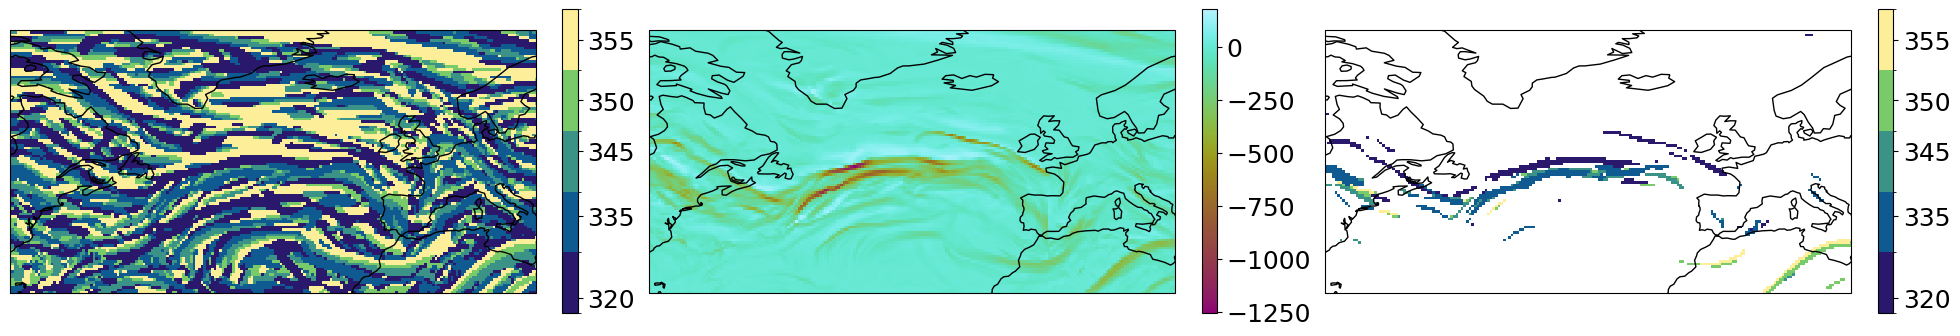

In [ ]:
clu = Clusterplot(1, 3, get_region(ds))
lon, lat = ds.lon.values, ds.lat.values
to_plot = ds.lev[ds["criterion"][100, :].argmin(dim='lev')].values
cmap = colormaps.haline
ticks = np.unique(to_plot)
ticks2 = np.concatenate([[315], ticks, [360]]) 
norm = BoundaryNorm((ticks2[:-1] + ticks2[1:]) / 2, cmap.N)
im = clu.axes[0].pcolormesh(lon, lat, to_plot, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
clu.fig.colorbar(im, ax=clu.axes[0], ticks=ticks, spacing='uniform')
to_plot = ds["criterion"][100, :].min(dim='lev')
im = clu.axes[1].pcolormesh(lon, lat, to_plot.values, transform=ccrs.PlateCarree(), cmap=colormaps.hawaii)
clu.fig.colorbar(im, ax=clu.axes[1])
to_plot = ds.lev[ds["criterion"][100, :].argmin(dim='lev')].where(to_plot < -200).values
im = clu.axes[2].pcolormesh(lon, lat, to_plot, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
clu.fig.colorbar(im, ax=clu.axes[2], ticks=ticks, spacing='uniform')

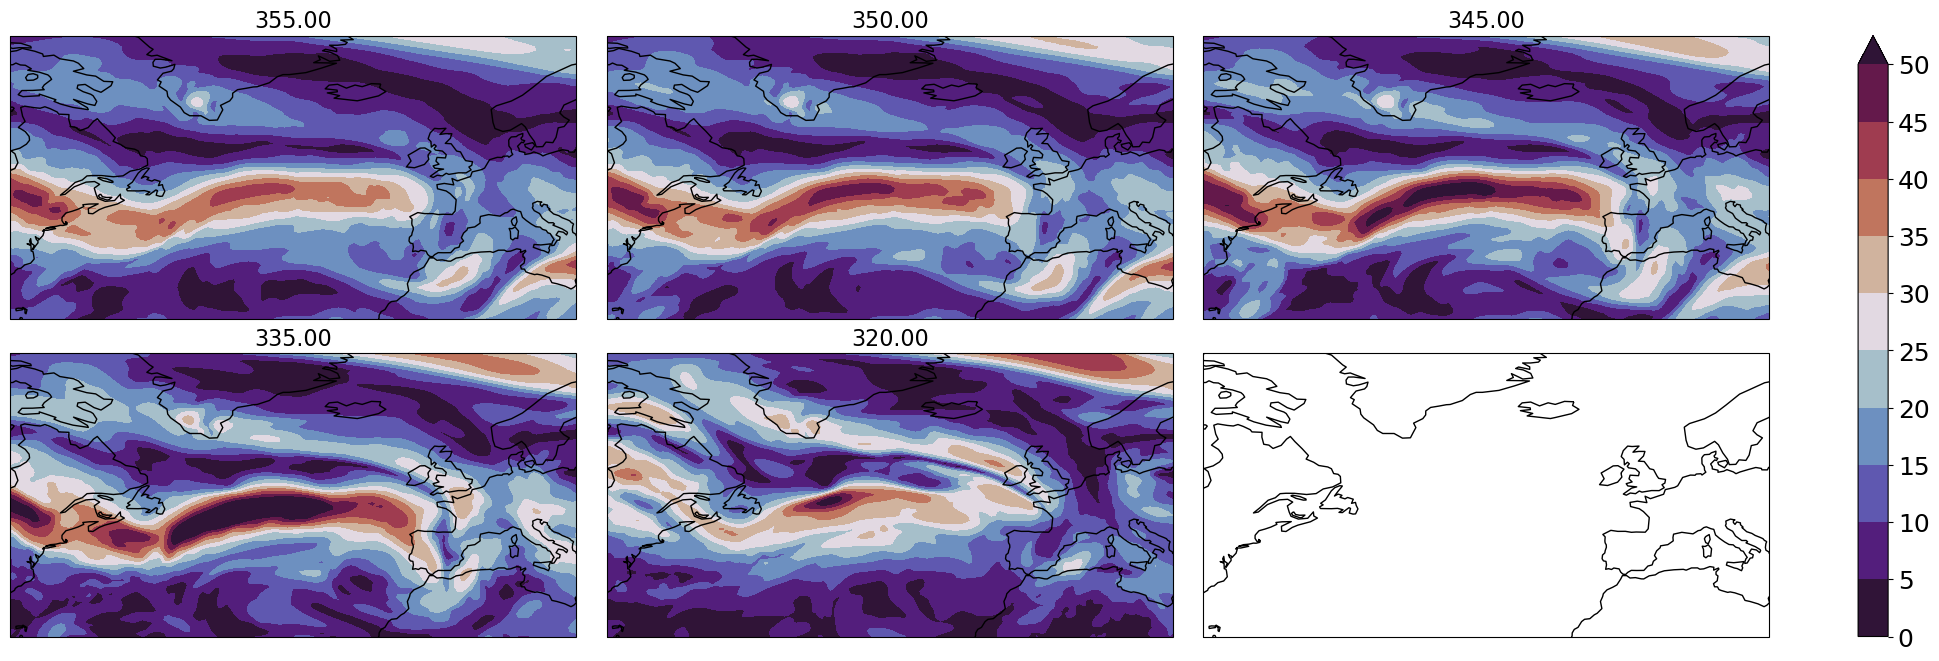

In [ ]:
clu = Clusterplot(2, 3, get_region(ds["P"]))
_ = clu.add_contourf([ds["s"][100, itheta] for itheta in range(5)], nlevels=11, q=0.99, titles=ds.lev.values)

## plev, v6

In [2]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2023), "all", -80, 30, 20, 75
)
exp_s.find_jets(15, 4)

  0%|          | 208/51408 [02:52<11:47:20,  1.21it/s]


KeyboardInterrupt: 

In [13]:
iterable = (ds.sel(time=time_) for time_ in ds.time.values)
jetfinder = JetFinder(
    preprocess=default_preprocess,
    compute_criterion=partial(flatten_by, by="s_smo"),
    define_mask=partial(
        define_mask_wind_speed, 
        criterion_threshold=25,
        distance_function=pairwise_distances,
    ),
    refine_jets=partial(
        jets_from_mask,
        compute_weights=compute_weights_wind_speed,
        jet_cutoff=2e8,
        min_size=700,
    ),
)

In [14]:
ds = xr.Dataset({"s": exp_s.da})
ds = jetfinder.pre_loop_call(ds)

[########################################] | 100% Completed | 3.97 sms


: 

: 

In [12]:
list(tqdm(map(jetfinder.loop_call, iterable), total=ds["s"].shape[0]))

  0%|          | 0/51408 [00:00<?, ?it/s]


KeyError: "No variable named 's_smo'. Variables on the dataset include ['lon', 'lat', 'lev', 'time', 's']"

In [3]:
jetfinder = JetFinder(
    preprocess=partial(smooth, smooth_map={"lon+lat": ("fft", 0.2)}),
    compute_criterion=partial(flatten_by, by="s"),
    define_mask=partial(
        define_mask_wind_speed, 
        criterion_threshold=25,
        distance_function=pairwise_distances,
    ),
    refine_jets=partial(
        jets_from_mask,
        compute_weights=compute_weights_wind_speed,
        jet_cutoff=2e8,
        min_size=500,
    ),
)

In [ ]:
jets_many_levs = jetfinder.call(ds_1, processes=13)

In [4]:
jets_fewer_levs = jetfinder.call(ds_2, processes=13)

[########################################] | 100% Completed | 155.39 s


 45%|████▍     | 13642/30544 [1:10:41<1:27:35,  3.22it/s]Process ForkPoolWorker-13:
Process ForkPoolWorker-9:
Process ForkPoolWorker-7:
Traceback (most recent call last):
  File "/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
           ^^^^

KeyboardInterrupt: 

## step by step

In [102]:
ds_2_flat = jetfinder.pre_loop_call(ds_2)
ds = ds_2_flat.isel(time=0)
points, distance_matrix = jetfinder.define_mask(ds)

[########################################] | 100% Completed | 4.07 sms


In [130]:
jets = jets_from_mask(ds, points, distance_matrix, compute_weights_criterion)

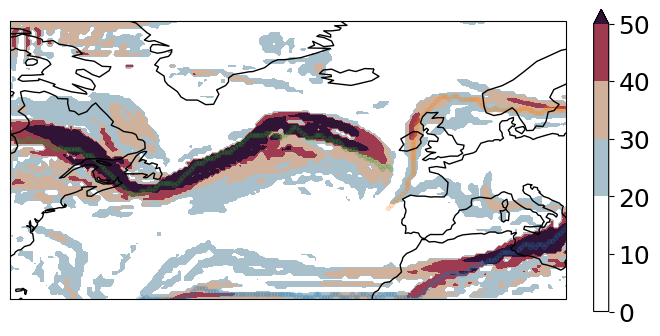

In [131]:
it = 0
clu = Clusterplot(1, 1, get_region(ds_2_flat))
_ = clu.add_contourf([ds_2_flat.isel(time=it)["s"]], transparify=2, q=0.95)
points, dist_matrix = jetfinder.define_mask(ds)
ax = clu.axes[0]
for group in jets:
    ax.scatter(*group[["lon", "lat"]].to_numpy().T, alpha=0.2, marker=".")


In [18]:
ds = ds_2_flat.isel(time=it)
compute_weights=compute_weights_criterion
jet_cutoff=5e2
jets = []
for i, (group, dist_mat) in enumerate(zip(groups, dist_mats)):
    is_nei = (dist_mat > 0) & (dist_mat < 1)
    weights = compute_weights(ds, group, is_nei)
    masked_weights = np.ma.array(weights, mask=~is_nei)
    graph = create_graph(masked_weights, dist_mat)
    candidates = list(np.unravel_index(np.argmax(dist_mat), dist_mat.shape))
    im = candidates[np.argmax(group["s"].iloc[candidates])]
    dmat, Pr = shortest_path(
        graph, directed=False, return_predecessors=True, indices=im
    )
    furthest = np.argsort(dist_mat[im])[::-1]
    splits = get_splits(group["s"].to_numpy(), Pr.copy(), furthest, jet_cutoff)
    jets.extend(jets_from_predecessor(group, splits, Pr, jet_cutoff))
    if i == 1:
        break

In [19]:
nco, labels = connected_components(graph)

/scratch/local/5494609/ipykernel_102302/713300651.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*group[["lon", "lat"]].iloc[mask].to_numpy().T, c=colors[i])
/scratch/local/5494609/ipykernel_102302/713300651.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*group[["lon", "lat"]].iloc[mask].to_numpy().T, c=colors[i])
/scratch/local/5494609/ipykernel_102302/713300651.py:3: UserWarning: *c* argum

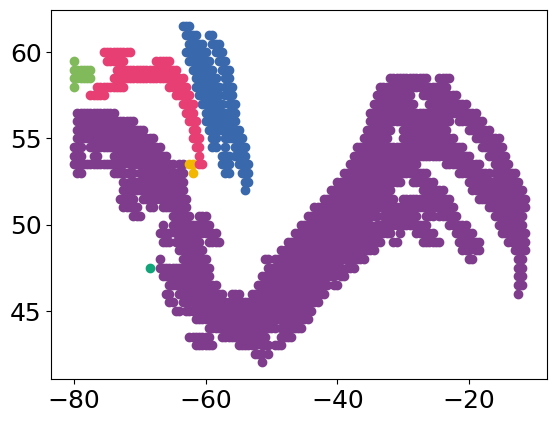

In [20]:
colors = colormaps.bold(np.arange(12))
for i, mask in enumerate(labels_to_mask(labels).T):
    plt.scatter(*group[["lon", "lat"]].iloc[mask].to_numpy().T, c=colors[i])

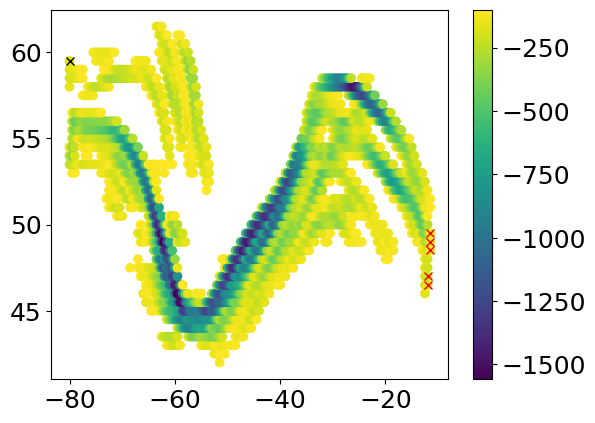

In [21]:
im_ = plt.scatter(*group[["lon", "lat"]].to_numpy().T, c=group["criterion"])
plt.colorbar(im_)
plt.plot(group["lon"].iloc[im], group["lat"].iloc[im], 'kx')
k = slice(0, 5)
plt.plot(group["lon"].iloc[furthest[k]], group["lat"].iloc[furthest[k]], 'rx')

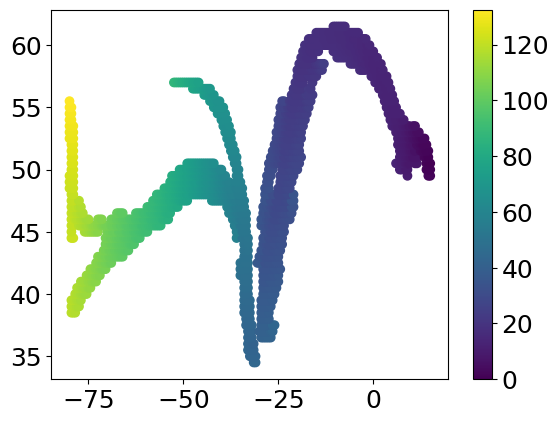

In [126]:
im_ = plt.scatter(*group[["lon", "lat"]].to_numpy().T, c=dmat)
plt.colorbar(im_)

In [127]:
(ds_2_flat.isel(time=it)["criterion"] < -150).mean()

<xarray.DataArray 'criterion' ()>
array(0.10876)
Coordinates:
    time     datetime64[ns] 1959-07-03T12:00:00

# Anim demo

MovieWriter ffmpeg unavailable; using Pillow instead.


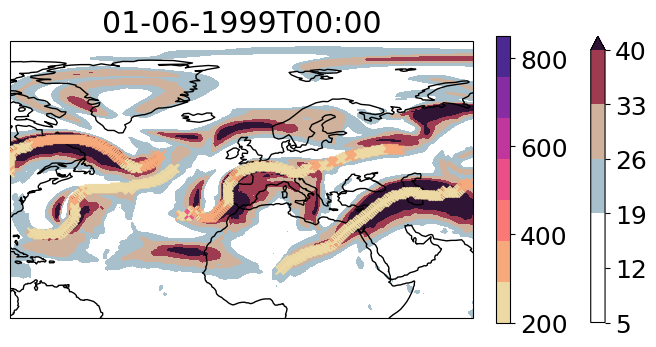

In [30]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, get_region(ds_2))
fig = clu.fig
ax = clu.axes[0]
times = ds_2.time
lon, lat = ds_2.lon.values, ds_2.lat.values
ds_flat = flatten_by(ds_2, "s")
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [ds_flat["s"].isel(time=0)], transparify=2, q=0.9
)
cs = ax.contourf(
    lon, lat, ds_flat["s"].isel(time=0).values, **kwargs_contourf
)
cmap_scatter = colormaps.agsunset_r
norm_scatter = Normalize(ds_2.lev.min(), ds_2.lev.max())
offsets = []
colors = []
for jet in jets_fewer_levs[0]:
    offsets.append(jet[["lon", "lat"]])
    colors.append(jet["lev"])
pc = ax.scatter(*offsets[0].to_numpy().T, c=colors[0].tolist(), marker='x', norm=norm_scatter, cmap=cmap_scatter, zorder=100)
pc.set_offsets(np.concatenate(offsets))
pc.set_array(np.concatenate(colors))
cbar = fig.colorbar(cs, shrink=0.75)
cbar2 = fig.colorbar(pc, shrink=0.75)

def animate(i):
    global pc
    global cs
    for c in cs.collections:
        c.remove()
    offsets = []
    colors = []
    for jet in jets_fewer_levs[i]:
        offsets.append(jet[["lon", "lat"]])
        colors.append(jet["lev"])
    try:
        offsets = np.concatenate(offsets)
        colors = np.concatenate(colors)
    except ValueError:
        offsets = np.asarray([[0, 0]])
        colors = [0.5]
    pc.set_offsets(offsets)
    pc.set_array(colors)
    cs = ax.contourf(
        lon, lat, ds_flat["s"].isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(times[i].dt.strftime("%d-%m-%YT%H:00").item())
    return pc, cs


ani = FuncAnimation(fig, animate, frames=len(times) - 1)
ani.save("Figures/jet_anim_fewer_levs.gif", dpi=150, fps=2)

MovieWriter ffmpeg unavailable; using Pillow instead.


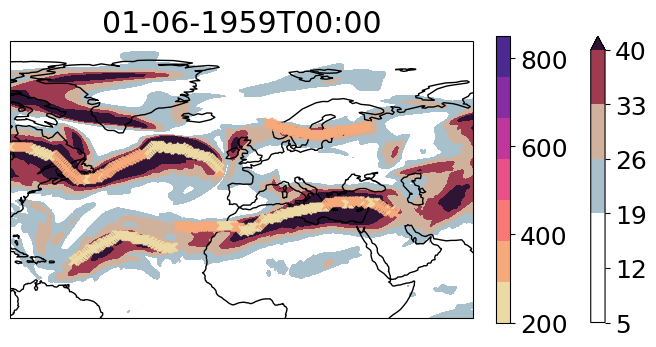

In [17]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, get_region(ds_1))
fig = clu.fig
ax = clu.axes[0]
times = ds_1.time
lon, lat = ds_1.lon.values, ds_1.lat.values
ds_flat = flatten_by(ds_1, "s")
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [ds_flat["s"].isel(time=0)], transparify=2, q=0.9
)
cs = ax.contourf(
    lon, lat, ds_flat["s"].isel(time=0).values, **kwargs_contourf
)
cmap_scatter = colormaps.agsunset_r
norm_scatter = Normalize(ds_1.lev.min(), ds_1.lev.max())
offsets = []
colors = []
for jet in jets_many_levs[0]:
    offsets.append(jet[["lon", "lat"]])
    colors.append(jet["lev"])
pc = ax.scatter(*offsets[0].to_numpy().T, c=colors[0].tolist(), marker='x', norm=norm_scatter, cmap=cmap_scatter, zorder=100)
pc.set_offsets(np.concatenate(offsets))
pc.set_array(np.concatenate(colors))
cbar = fig.colorbar(cs, shrink=0.75)
cbar2 = fig.colorbar(pc, shrink=0.75)

def animate(i):
    global pc
    global cs
    for c in cs.collections:
        c.remove()
    offsets = []
    colors = []
    for jet in jets_many_levs[i]:
        offsets.append(jet[["lon", "lat"]])
        colors.append(jet["lev"])
    try:
        offsets = np.concatenate(offsets)
        colors = np.concatenate(colors)
    except ValueError:
        offsets = np.asarray([[0, 0]])
        colors = [0.5]
    pc.set_offsets(offsets)
    pc.set_array(colors)
    cs = ax.contourf(
        lon, lat, ds_flat["s"].isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(times[i].dt.strftime("%d-%m-%YT%H:00").item())
    return pc, cs


ani = FuncAnimation(fig, animate, frames=len(times) - 1)
ani.save("Figures/jet_anim_many_levs.gif", dpi=150, fps=2)

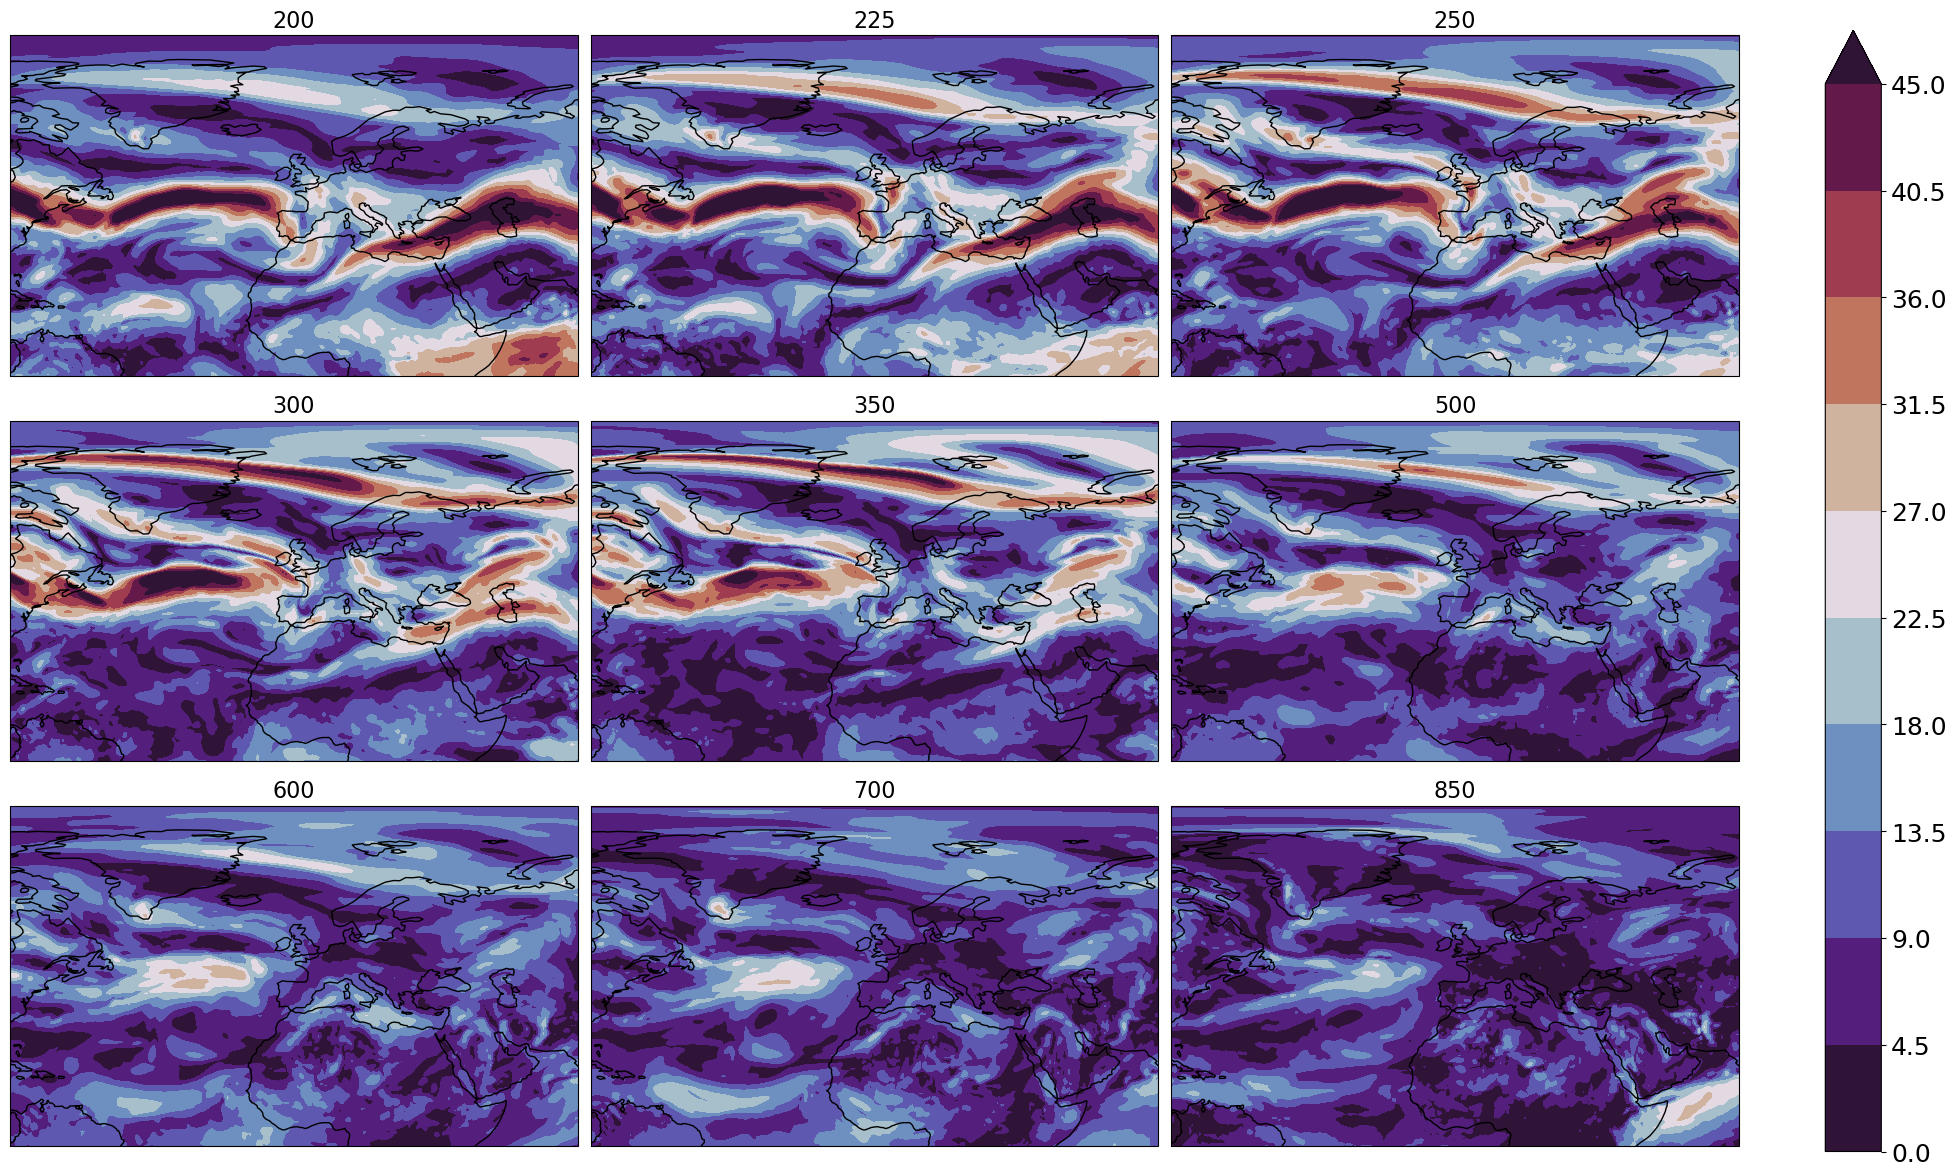

In [ ]:
clu = Clusterplot(3, 3, get_region(ds))
_ = clu.add_contourf([ds["s"][100, ip_] for ip_ in range(9)], nlevels=11, q=0.99, titles=ds.lev.values)

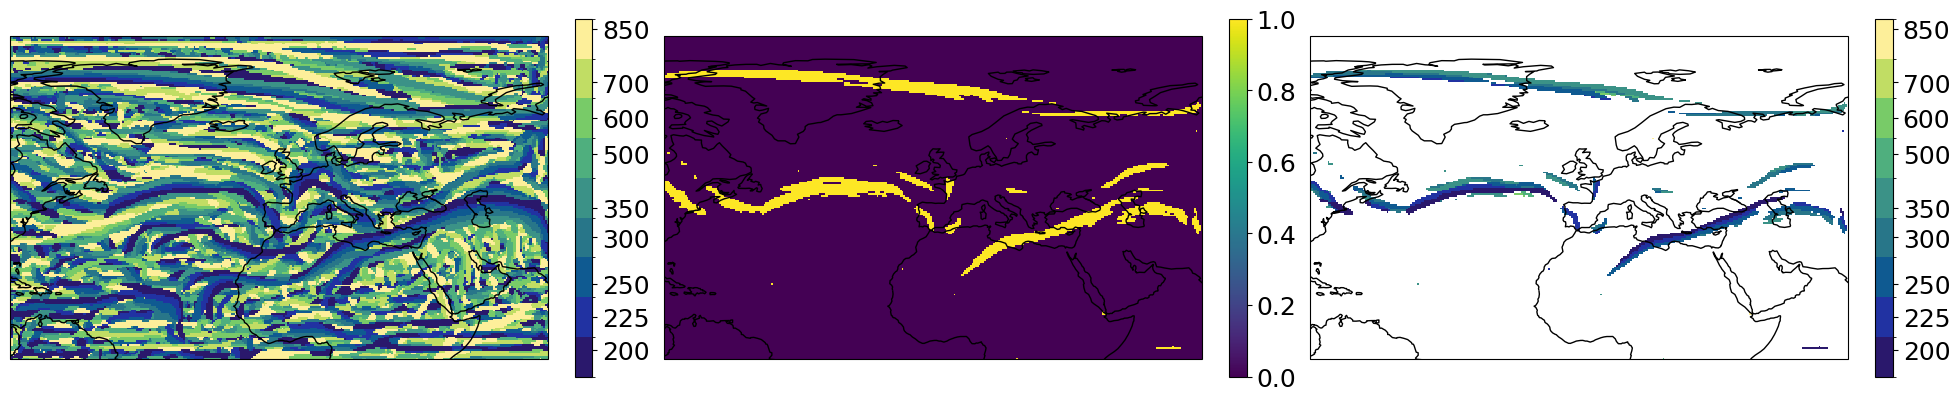

In [ ]:
clu = Clusterplot(1, 3, get_region(ds))
lon, lat = ds.lon.values, ds.lat.values
to_plot = ds.lev[ds["criterion"][100, :].argmin(dim='lev')].values
cmap = colormaps.haline
ticks = np.unique(to_plot)
ticks2 = np.concatenate([[150], ticks, [900]]) 
norm = BoundaryNorm((ticks2[:-1] + ticks2[1:]) / 2, cmap.N)
im = clu.axes[0].pcolormesh(lon, lat, to_plot, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
clu.fig.colorbar(im, ax=clu.axes[0], ticks=ticks, spacing='uniform')
to_plot = ds["criterion"][100, :].min(dim='lev')
im = clu.axes[1].pcolormesh(lon, lat, to_plot.values < -150, transform=ccrs.PlateCarree())
clu.fig.colorbar(im, ax=clu.axes[1])
to_plot = ds.lev[ds["criterion"][100, :].argmin(dim='lev')].where(to_plot < -150).values
im = clu.axes[2].pcolormesh(lon, lat, to_plot, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
clu.fig.colorbar(im, ax=clu.axes[2], ticks=ticks, spacing='uniform')

In [ ]:
lon, lat = ds.lon.values, ds.lat.values
maxlev = ds["criterion"][0].argmin(dim="lev")
append_to_groups = [ds["s"][0]]
append_to_groups = [atg.isel(lev=maxlev) for atg in append_to_groups]
append_to_groups.append(ds["criterion"][0].lev[maxlev])
criterion = ds["criterion"][0].isel(lev=maxlev)
X = ds["criterion"][0].values
idxs = np.where(X < -150)
append_names = [atg.name for atg in append_to_groups]
append_to_groups = [atg.values[idxs[0], idxs[1]] for atg in append_to_groups]
points = np.asarray([lon[idxs[1]], lat[idxs[0]], *append_to_groups]).T
points = pd.DataFrame(points, columns=["lon", "lat", *append_names])
points.iloc[np.ones(len(points), dtype=bool)]

lon  lat         s    lev
0    -66.5  0.0  7.184317  600.0
1    -66.5  0.0  7.184317  600.0
2    -66.5  0.0  7.184317  600.0
3    -66.5  0.0  7.184317  600.0
4    -66.5  0.0  7.184317  600.0
...    ...  ...       ...    ...
7483 -23.0  3.5  9.318861  700.0
7484 -23.0  3.5  9.318861  700.0
7485 -30.5  4.0  8.579989  300.0
7486 -27.5  4.0  9.335428  600.0
7487 -27.5  4.0  9.335428  600.0

[7488 rows x 4 columns]

In [ ]:
thisds = ds.loc[dict(time=ds.time[0].values)]
indexer = points
cols = [col for col in ["lev", "lon", "lat"] if col in indexer]
kwargs = {col: xr.DataArray(indexer[col].to_numpy(), dims="point") for col in cols}
thisds["s"].loc[kwargs]

<xarray.DataArray 's' (point: 7488)>
array([7.18432, 7.18432, 7.18432, ..., 8.57999, 9.33543, 9.33543],
      dtype=float32)
Coordinates:
    lon      (point) float32 -66.5 -66.5 -66.5 -66.5 ... -23.0 -30.5 -27.5 -27.5
    lat      (point) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 3.5 3.5 3.5 4.0 4.0 4.0
    lev      (point) int32 600 600 600 600 600 600 ... 700 700 700 300 600 600
    time     datetime64[ns] 1959-06-01
Dimensions without coordinates: point

In [ ]:
ds["s"][0].isel(lev=maxlev)

<xarray.DataArray 's' (lat: 181, lon: 301)>
array([[7.74886, 6.7384 , 6.83476, ..., 8.63268, 1.34417, 4.1188 ],
       [3.50887, 7.10968, 4.52787, ..., 1.52373, 1.75193, 7.77564],
       [4.96703, 1.42063, 1.26403, ..., 2.15626, 2.32916, 7.37162],
       ...,
       [8.48636, 5.71558, 5.71365, ..., 2.10559, 2.11525, 8.76879],
       [2.74663, 5.90244, 5.89979, ..., 4.14373, 4.14231, 2.31312],
       [0.00196, 0.00127, 0.00127, ..., 0.00196, 0.00196, 0.00196]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -80.0 -79.5 -79.0 -78.5 -78.0 ... 68.5 69.0 69.5 70.0
  * lat      (lat) float32 0.0 0.5 1.0 1.5 2.0 2.5 ... 88.0 88.5 89.0 89.5 90.0
    lev      (lat, lon) int32 600 600 600 600 600 600 ... 225 225 225 225 225
    time     datetime64[ns] 1959-06-01

## 2PVU

In [ ]:
ds_2PVU = xr.Dataset()
ds_2PVU['u'] = open_da("ERA5", "2PVU", "u", "6H", 1959, "JJA", -80, 20, 25, 75).load()
mask_valid = ds_2PVU['u'] > -120
ds_2PVU['u'] = ds_2PVU['u'].where(mask_valid, 0)
ds_2PVU['v'] = open_da("ERA5", "2PVU", "v", "6H", 1959, "JJA", -80, 20, 25, 75).load().where(mask_valid, 0)
ds_2PVU['s'] = open_da("ERA5", "2PVU", "s", "6H", 1959, "JJA", -80, 20, 25, 75).load().where(mask_valid, 0)
ds_2PVU['theta'] = open_da("ERA5", "2PVU", "theta", "6H", 1959, "JJA", -80, 20, 25, 75).load().where(mask_valid, 0)
ds_2PVU['P'] = open_da("ERA5", "2PVU", "P", "6H", 1959, "JJA", -80, 20, 25, 75).load().where(mask_valid, 0)
ds_2PVU = compute_criterion(ds_2PVU)

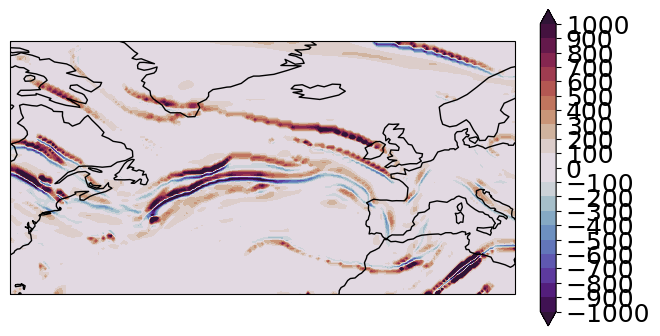

In [ ]:
clu = Clusterplot(1, 1, get_region(ds_2PVU))
_ = clu.add_contourf([ds_2PVU["criterion"][100]], nlevels=11, q=0.99)

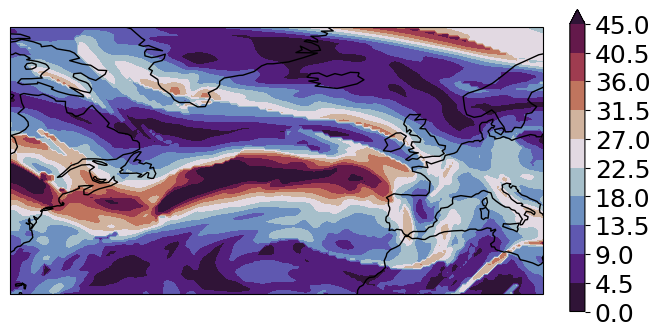

In [ ]:
clu = Clusterplot(1, 1, get_region(ds_2PVU))
_ = clu.add_contourf([ds_2PVU["s"][100]], nlevels=11, q=0.96)

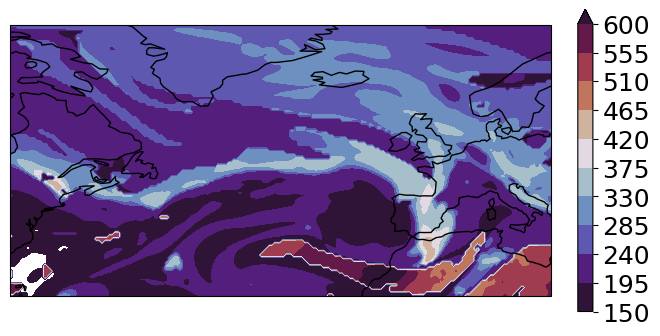

In [ ]:
clu = Clusterplot(1, 1, get_region(ds_2PVU))
_ = clu.add_contourf([ds_2PVU["P"][100]], nlevels=11, q=0.99)

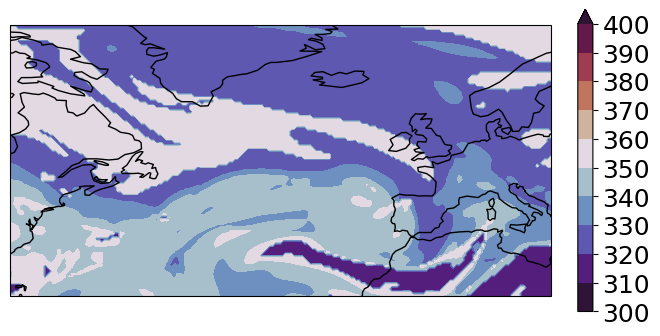

In [ ]:
clu = Clusterplot(1, 1, get_region(ds_2PVU))
_ = clu.add_contourf([ds_2PVU["theta"][100]], nlevels=11, q=0.99)

In [ ]:
preprocess = default_preprocess
define_blobs = partial(define_blobs_wind_speed, min_size=750)
refine_jets = partial(refine_jets_shortest_path, compute_weights=compute_weights_wind_speed, jet_cutoff=2.4e3)
jet_finder = JetFinder(
    preprocess=preprocess, define_blobs=define_blobs, refine_jets=refine_jets
)
find_all_jets(jet_finder, ds, 14, 10)

In [ ]:
thisds = ds.isel(time=it)
preprocess = partial(smooth, smooth_map={"lon+lat": ("fft", 0.4)})
for varname in ['u', 'v', 's']:
    thisds[f'{varname}_smo'] = preprocess(thisds[varname])
%lprun -f define_blobs_generic define_blobs_generic(thisds["s"], thisds["s"], criterion_threshold=30, distance_function=my_pairwise, min_size=750)
it = it + 1

Timer unit: 1e-09 s

Total time: 0.207846 s
File: /storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py
Function: define_blobs_generic at line 81

Line #      Hits         Time  Per Hit   % Time  Line Contents
    81                                           def define_blobs_generic(
    82                                               criterion: xr.DataArray,
    83                                               *append_to_groups: xr.DataArray,
    84                                               criterion_threshold: float = 0,
    85                                               distance_function: Callable = pairwise_distances,
    86                                               distance_threshold: float = 0.75,
    87                                               min_size: int = 50,
    88                                           ) -> Tuple[list, list]:
    89         1      95169.0  95169.0      0.0      lon, lat = criterion.lon.values, criterion.lat.values
   

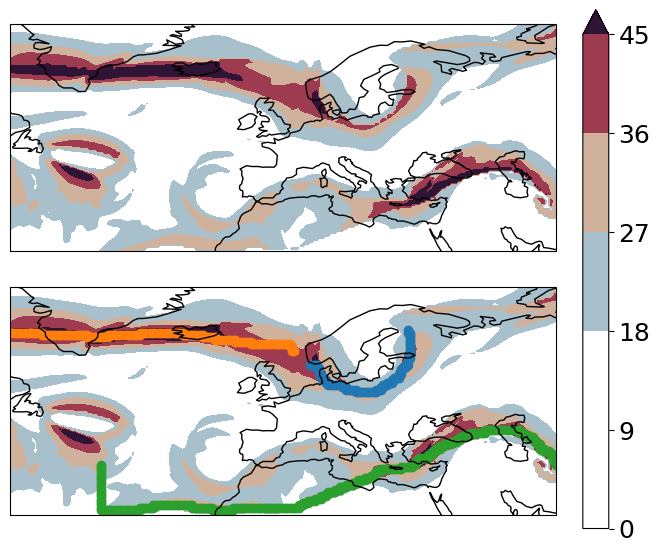

In [ ]:
clu = Clusterplot(2, 1, get_region(ds))
it = 60
clu.add_contourf([ds['s'][it], ds['s'][it]], transparify=2, q=0.95)
ax = clu.axes[1]
for jet in all_jets[it]:
    if np.sum(jet[:, 2]) > 1:
        ax.scatter(*jet[:, :2].T)

# the rest

In [ ]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_pvs= Experiment(
    "ERA5", "surf", "pvs", "6H", "all", [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, 'hourofyear', {'hourofyear': ('win', 4 * 10)}, None
)
da_pvs = exp_pvs.da
exp_s_low = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)
exp_T = Experiment(
    "ERA5", "surf", "t", "6H", (1940, 2023), [5, 6, 7, 8, 9], -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 10)}, None,
)
da_T = exp_T.da

In [ ]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(
    flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1]))
)
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_np = props_to_np(props_as_ds)
props_as_ds_anoms = compute_prop_anomalies(props_as_ds)
props_as_ds["exists"] = (~props_as_ds["mean_lon"].isnull()).astype(np.float32)
normalize = lambda da: (da - da.mean(axis=0)) / da.std(axis=0)
overlaps, vert_dists = compute_all_overlaps(all_jets, props_as_ds_uncat)
da_overlaps, da_vert_dists = overlaps_vert_dists_as_da(
    da_s, all_jets, props_as_ds_uncat, exp_s.path
)
props_as_ds["overlap"] = (da_overlaps > 0).mean(dim="lon")
props_as_ds["vert_dist"] = da_vert_dists.mean(dim="lon")
nao_summer = get_nao(da_s)
props_as_ds["nao"] = nao_summer

100%|██████████| 51408/51408 [00:24<00:00, 2083.84it/s]
